Hola **Christian**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:

# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()


## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

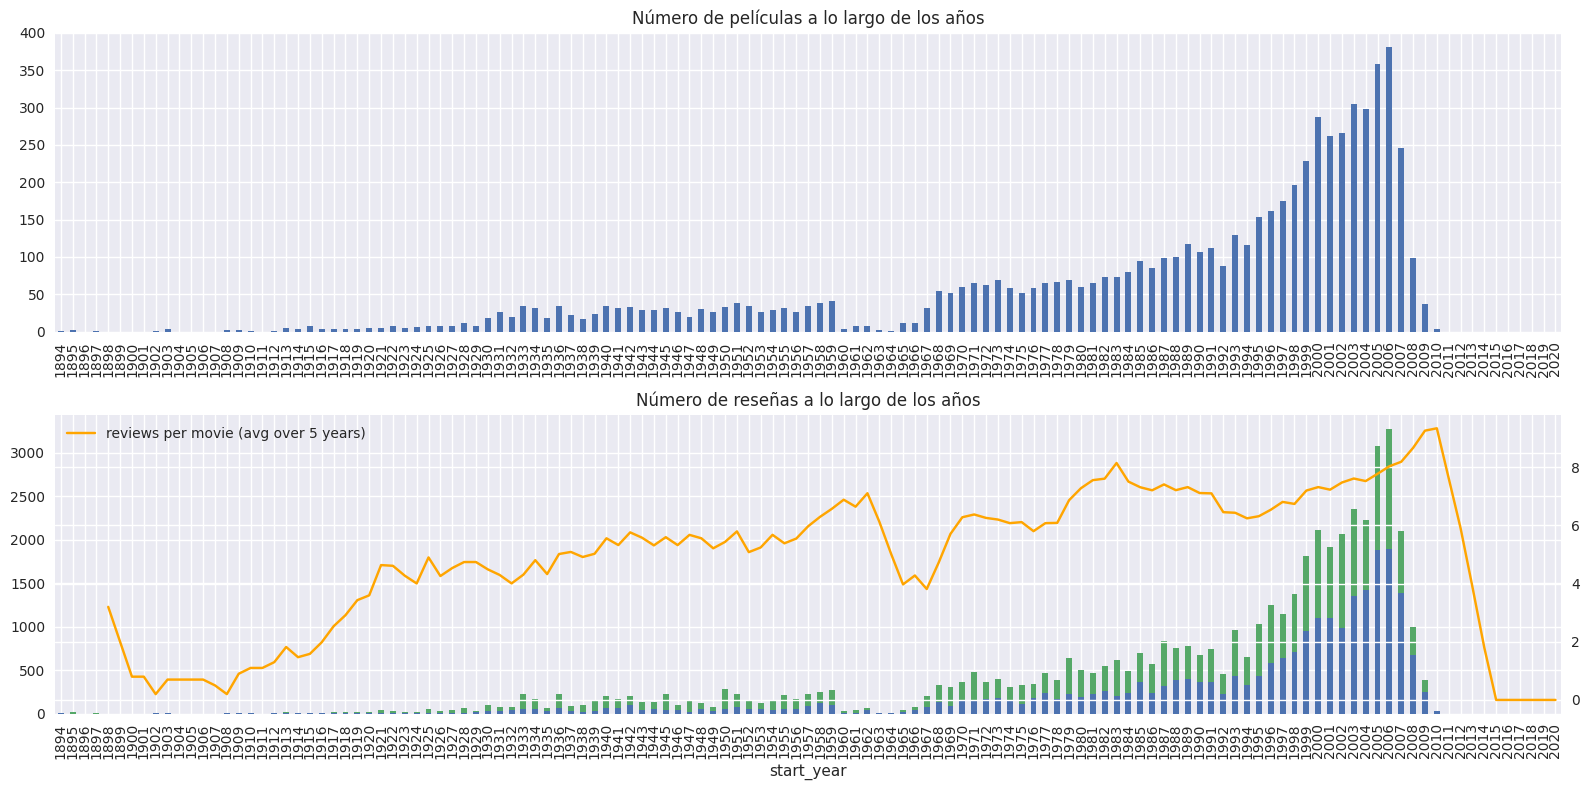

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

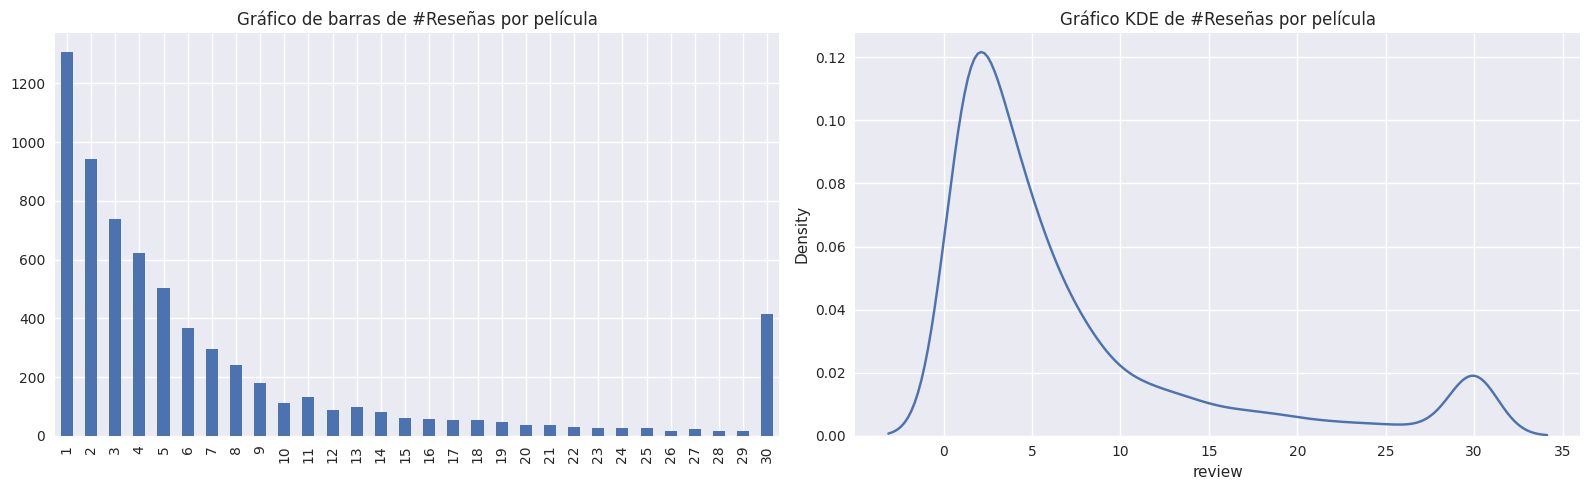

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

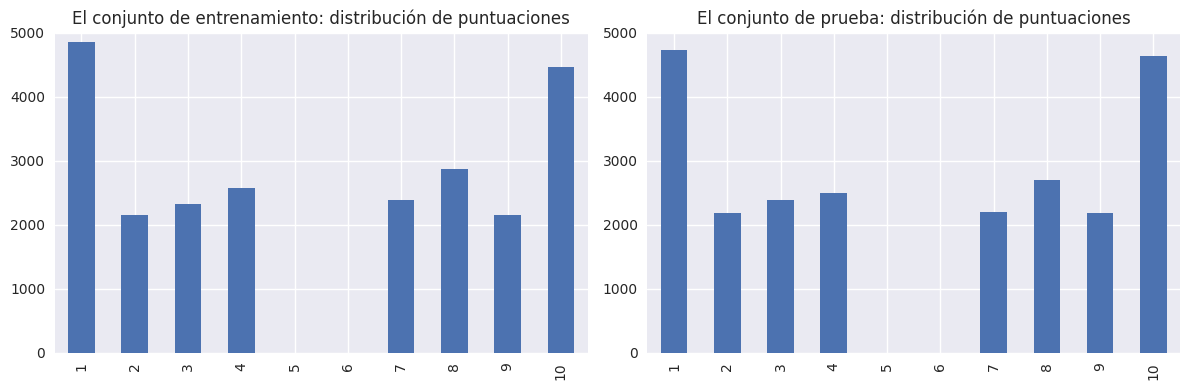

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


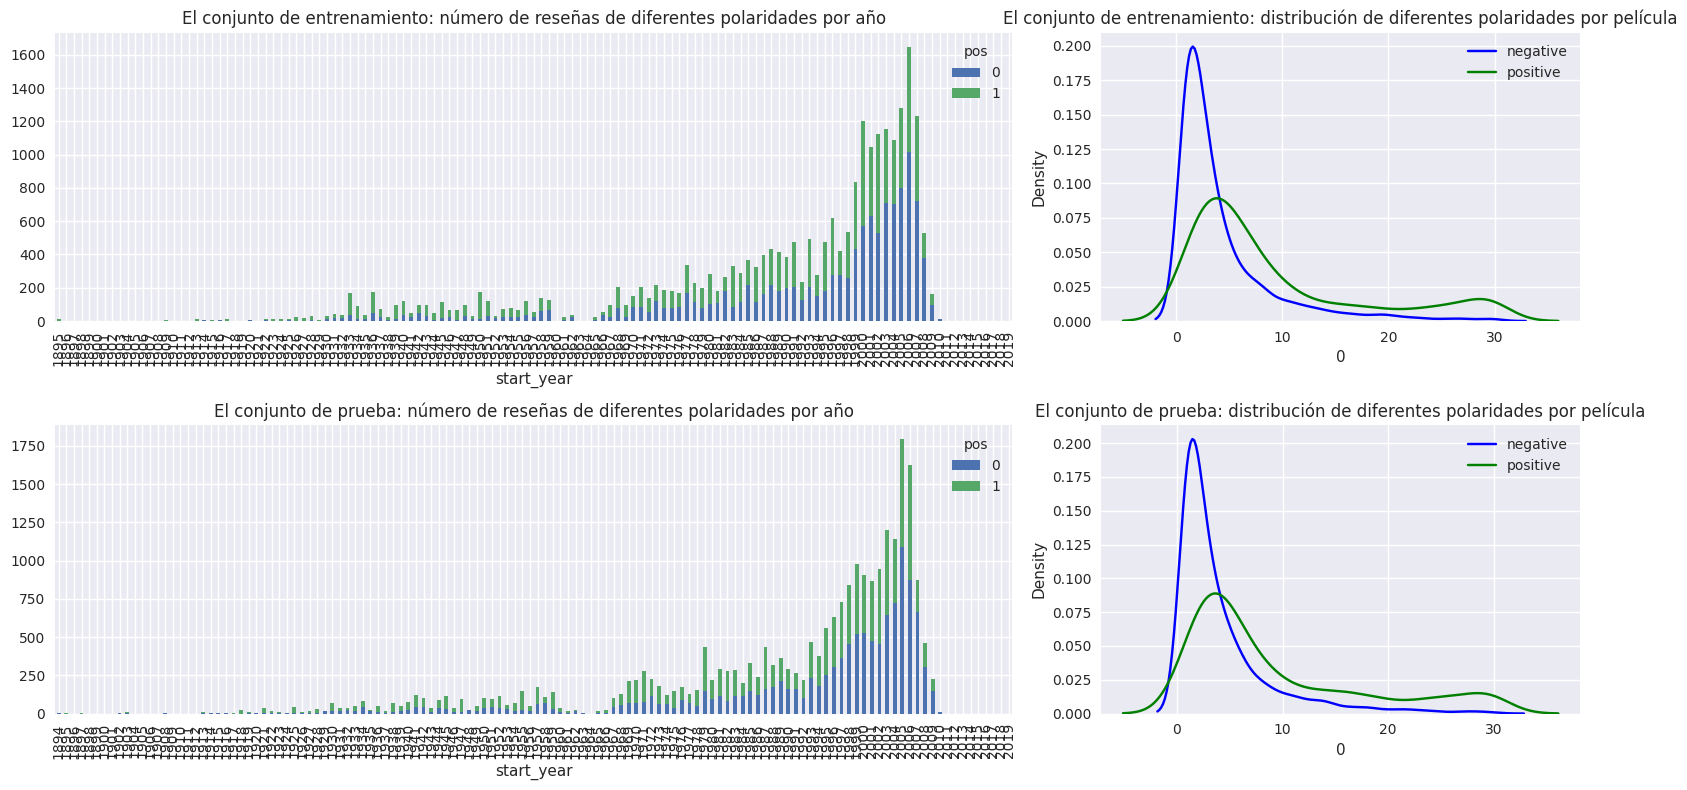

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, el EDA es un proceso necesario en cada proyecto para entender los datos con los que se trabajará por lo que siempre procura complementar con una redacción de las conclusiones de las gráficas mostradas
</div>

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [12]:

import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return


## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [13]:
import re

# Normalización básica de texto
df_reviews['review_norm'] = df_reviews['review'].apply(
    lambda x: re.sub(r'[^a-z\s]', '', x.lower())
)

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto! Realizaste un buen trabajo con la normalización y creando la función de evaluación. La normalización es un paso importante para evitar "ruido" en tus datos y estandarizar el hecho que las palabras estén en casos escritas con mayúsculas y en otros con minúsculas
</div>

## Trabajar con modelos

### Modelo 0 - Constante

In [15]:
from sklearn.dummy import DummyClassifier

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Ajustar con los datos de entrenamiento y transformar ambos conjuntos
train_features = tfidf.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf.transform(df_reviews_test['review_norm'])

print(train_features.shape)
print(test_features.shape)

(23796, 5000)
(23535, 5000)


📊 Evaluación: Regresión Logística
          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


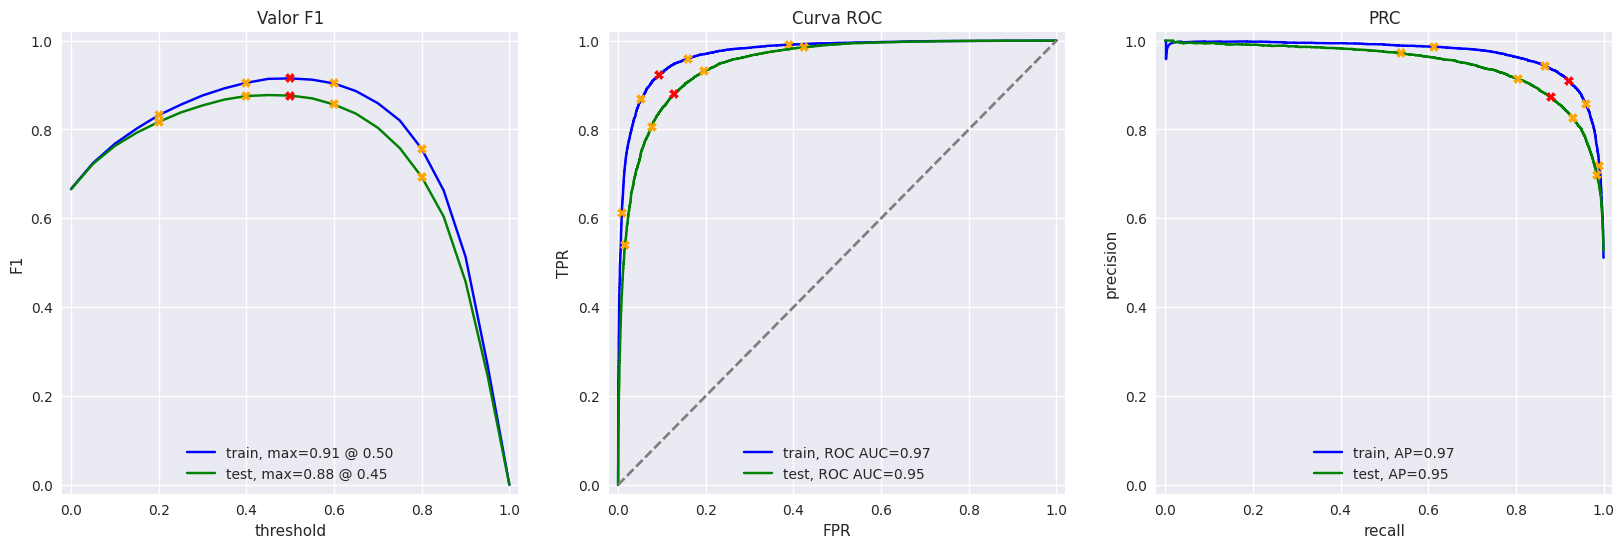

In [17]:
from sklearn.linear_model import LogisticRegression

# Modelo 1: Regresión Logística
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(train_features, train_target)

print("📊 Evaluación: Regresión Logística")
evaluate_model(model_lr, train_features, train_target, test_features, test_target)

📊 Evaluación: Gradient Boosting
          train  test
Accuracy   0.82  0.81
F1         0.83  0.82
APS        0.91  0.89
ROC AUC    0.91  0.89


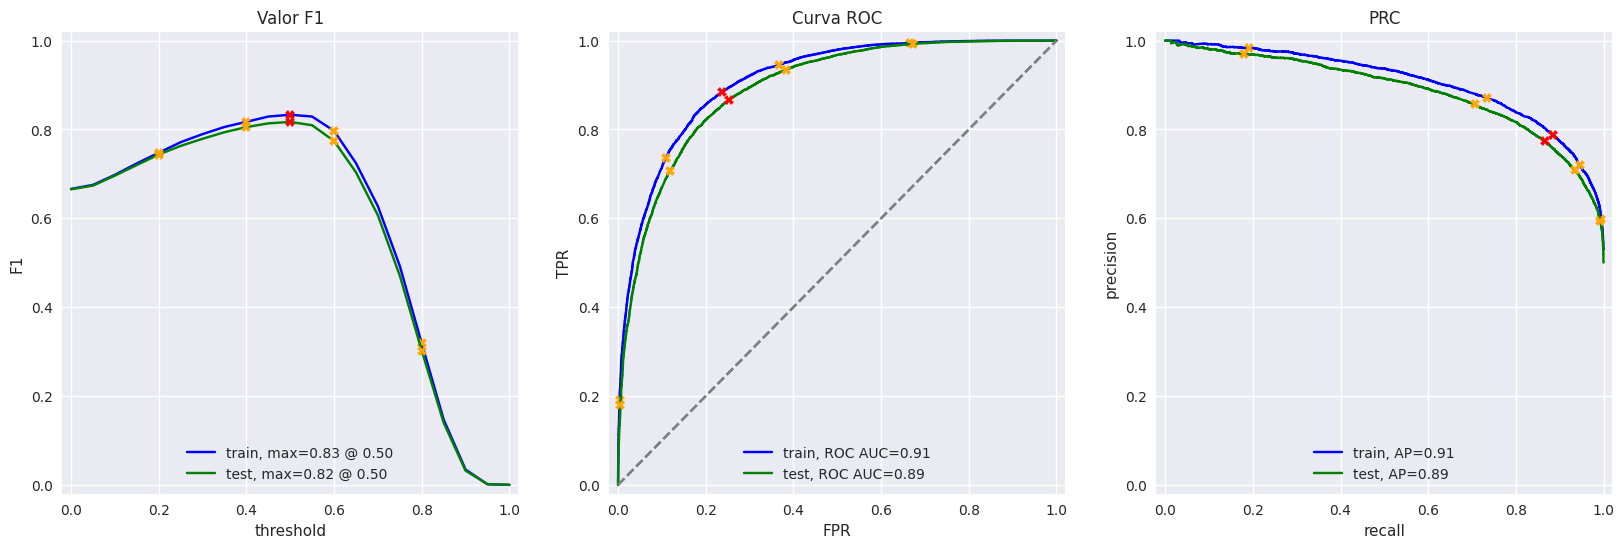

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

# Modelo 2: Gradient Boosting 
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(train_features.toarray(), train_target)

print("📊 Evaluación: Gradient Boosting")
evaluate_model(model_gb, train_features.toarray(), train_target, test_features.toarray(), test_target)

📊 Evaluación: Naive Bayes
          train  test
Accuracy   0.87  0.84
F1         0.87  0.84
APS        0.94  0.91
ROC AUC    0.94  0.92


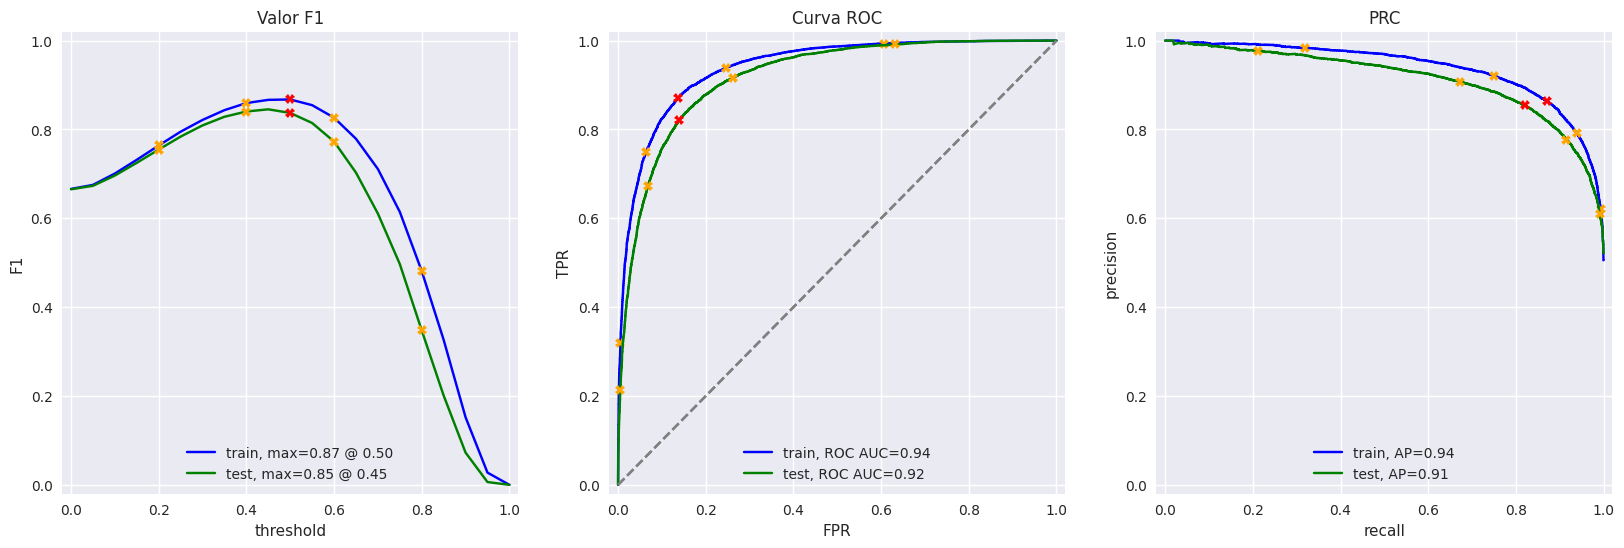

In [19]:
from sklearn.naive_bayes import MultinomialNB

# Modelo 3: Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(train_features, train_target)

print("📊 Evaluación: Naive Bayes")
evaluate_model(model_nb, train_features, train_target, test_features, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [21]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # minúsculas
    text = re.sub(r'[^a-z\s]', '', text)  # dejar solo letras y espacios
    words = text.split()
    words = [w for w in words if w not in stop_words]  # eliminar stopwords
    return ' '.join(words)

# Aplicar limpieza a los textos de entrenamiento y prueba
df_reviews_train['review_clean'] = df_reviews_train['review'].apply(preprocess_text)
df_reviews_test['review_clean'] = df_reviews_test['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
tfidf = TfidfVectorizer(max_features=5000)
train_features_1 = tfidf.fit_transform(df_reviews_train['review_clean'])
test_features_1 = tfidf.transform(df_reviews_test['review_clean'])

In [23]:
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


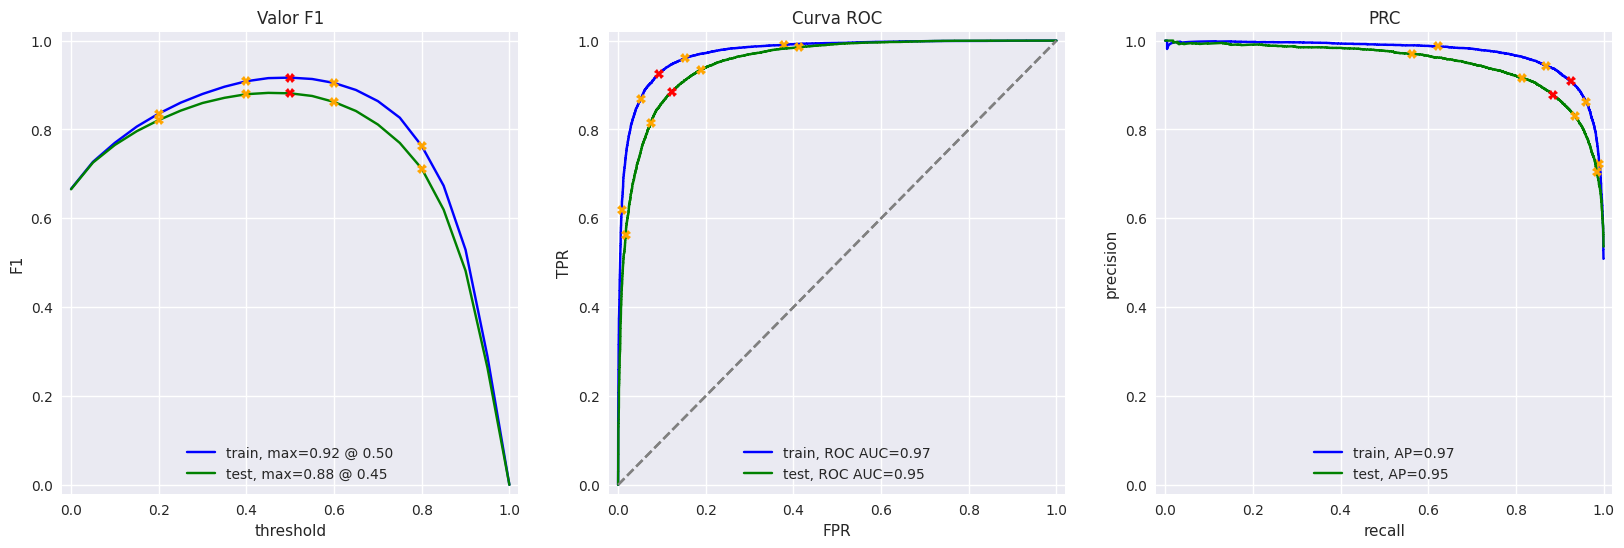

In [24]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

In [25]:
tfidf_vectorizer_2 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])

model_2 = GradientBoostingClassifier(random_state=42)
model_2.fit(train_features_2.toarray(), train_target)

GradientBoostingClassifier(random_state=42)

### Modelo 3 - spaCy, TF-IDF y LR

In [26]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [45]:
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Aplica la función a los conjuntos de entrenamiento y prueba
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [46]:

tfidf_vectorizer_3 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])


In [47]:
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

📊 Evaluación: Modelo 3 - spaCy + TF-IDF + LR
          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


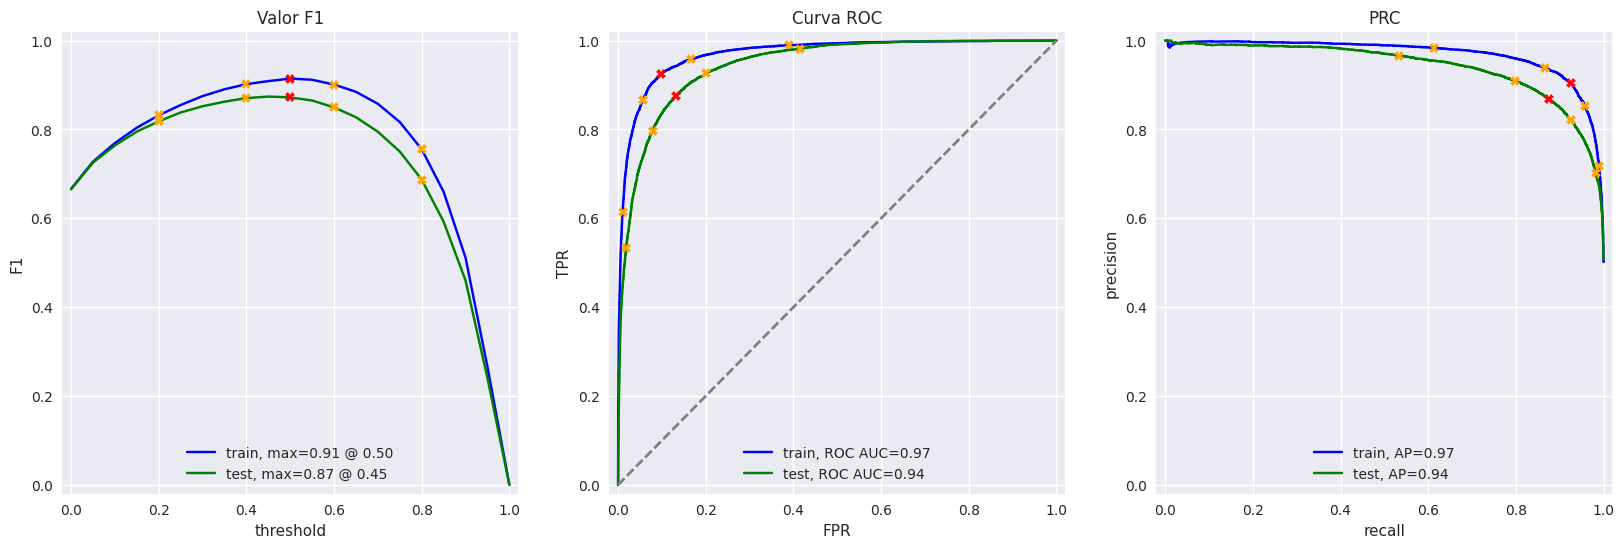

In [30]:
print("📊 Evaluación: Modelo 3 - spaCy + TF-IDF + LR")
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [31]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier

In [53]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# 1️⃣ Función de preprocesamiento (puedes reutilizar la del modelo 3)
def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_digit]
    return ' '.join(tokens)

# 2️⃣ Aplicar el preprocesamiento a train y test
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)


In [54]:
# 3️⃣ Crear el vectorizador TF-IDF
tfidf_vectorizer_4 = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_spacy'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spacy'])

In [55]:
# 4️⃣ Entrenar el modelo LightGBM
model_4 = LGBMClassifier(random_state=42)
model_4.fit(train_features_4, train_target)

LGBMClassifier(random_state=42)

📊 Evaluación: Modelo 4 - spaCy + TF-IDF + LightGBM
          train  test
Accuracy   0.98  0.87
F1         0.98  0.87
APS        1.00  0.94
ROC AUC    1.00  0.94


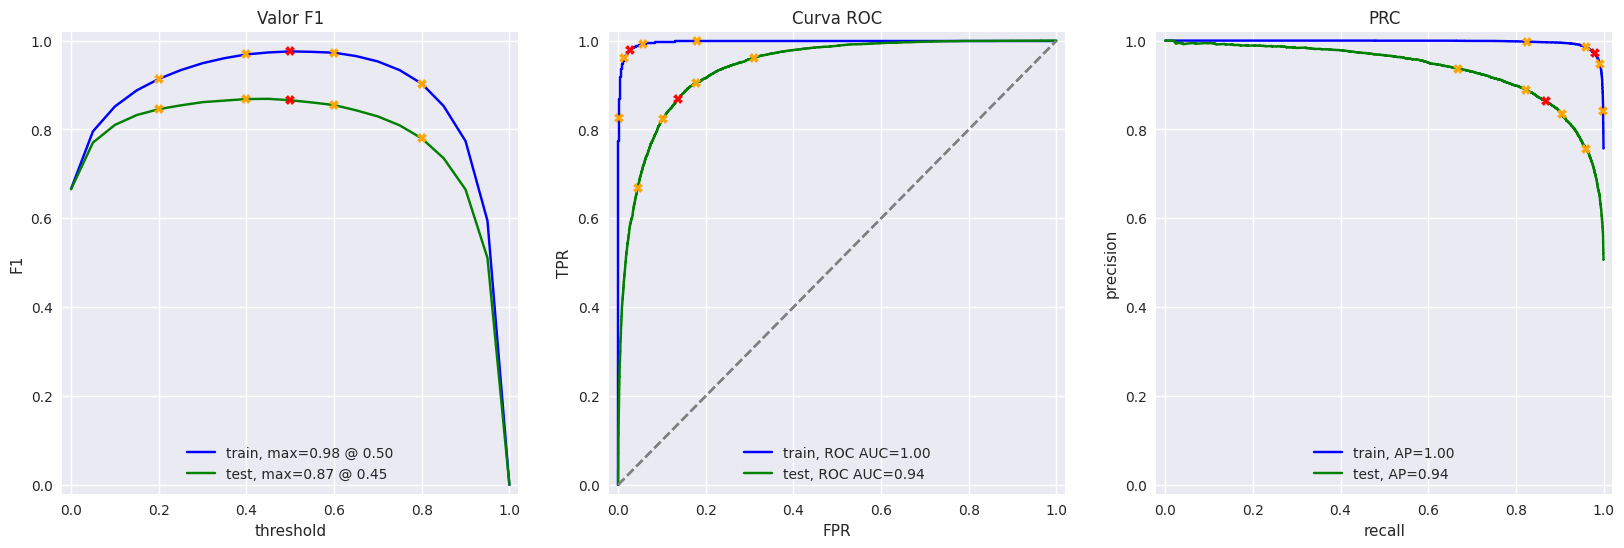

In [35]:
# 5️⃣ Evaluar el modelo
print("📊 Evaluación: Modelo 4 - spaCy + TF-IDF + LightGBM")
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Excelente! Entrenaste diferentes modelos y se obtuvieron métricas bastante buenas! Siempre procura buscar una forma amigable de explicar el resultado del performance en tu modelo, por ejemplo, las gráficas utilizadas aquí son muy buenas para explicar el comportamiento de los modelos
</div>

###  Modelo 9 - BERT

In [36]:
import math
import torch
import transformers
import numpy as np
from tqdm.auto import tqdm

In [37]:

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # 🔹 Texto → tokens + máscaras
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # agrega [CLS] y [SEP]
            max_length=max_length,        # longitud máxima
            truncation=True,              # recorta si es muy largo
            padding='max_length',         # rellena hasta max_length
            return_attention_mask=True,   # crea la attention mask
            return_tensors='pt'           # lo devuelve como tensor de PyTorch
        )
        ids_list.append(encoded['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoded['attention_mask'].squeeze().tolist())

    # 🔹 Seleccionar dispositivo
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    embeddings = []

    # 🔹 Obtener embeddings por lotes
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i : batch_size * (i + 1)]).to(device)

        # 💡 Crear atención mask batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        # [CLS] embedding → posición 0
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [39]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas


Buen dia!
Disculpe, e tratado de hacer este codigo que esta aqui arriba, y siempre que lo intento pasan al menos una media hora y despues la pagina se me cae, segun yo el codigo esta bien pero creo que mi computadora no esta aguantando tanto, podrian ayudarme a ver como resolver esto por favor?
segun yo el resto del codigo esta bien, pero es que en esta parte de aqui estoy atorado
Gracias
una disulpa

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Hola Christian, BERT es un modelo complejo que requiere un poder computacional alto y para esto se utilizan las GPU, si tu equipo no cuenta con una es por eso que el kernel del notebook "muere" ya que no logra realizar todas las operaciones necesarias para BERT.

Por esto en la descripción del proyecto se deja este modelo cómo opcional, si no tienes acceso a una GPU simplemente comenta todo el código referente a BERT y ejecuta el resto.

Recuerda en la parte final realizar la normalización de nuevas reseñas y probar los modelos que si pudiste entrenar, saludos!
</div>

## Mis reseñas

In [42]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(
    lambda x: re.sub(r'[^a-z\s]', '', x.lower())
)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 2

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  i did not simply like it not my kind of movie
0.63:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.60:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.60:  i didnt expect the reboot to be so good writers really cared about the source material
0.61:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.51:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.61:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [48]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.23:  i did not simply like it not my kind of movie
0.10:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.21:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22:  i didnt expect the reboot to be so good writers really cared about the source material
0.37:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [56]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(
    tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x)))
)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')



0.68:  i did not simply like it not my kind of movie
0.42:  well i was bored and felt asleep in the middle of the movie
0.67:  i was really fascinated with the movie
0.53:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.37:  i didnt expect the reboot to be so good writers really cared about the source material
0.64:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.29:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

Debido a las limitaciones de mi computadora no me fue posible correr BERT, hice de varios intentos
pero definitivamente no me funciono, de hecho aun quitandolo batalle un poco corriendo todas las cajas de codigo, pero finalmente se logro.

<div class="alert alert-block alert-info">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Lo importante es que se pudo avanzar, el proceso de aprendizaje es así. Si tienes curiosidad y quieres probar modelos cómo BERT te recomiendo probar la plataforma de Google Colab que te permite utilizar una GPU de manera gratuita sólo con tu cuenta `@gmail`
</div>

El Modelo 2 (TF-IDF con regresión logística) entregó probabilidades muy equilibradas, con valores entre 0.50 y 0.63, lo que sugiere un modelo conservador, capaz de distinguir opiniones positivas y negativas sin sobreajustarse

El Modelo 3, que aplicó una limpieza más agresiva y un nuevo vectorizador TF-IDF, mostró una tendencia a subestimar las reseñas positivas (valores muy bajos en textos positivos), lo cual indica posible pérdida de información semántica o sobreajuste al vocabulario.

El Modelo 4, que reutilizó la vectorización del modelo 3 pero con un nuevo ajuste, corrigió parcialmente ese problema, mostrando mayor estabilidad y separación entre reseñas positivas y negativas (valores entre 0.29 y 0.83)

Entre los modelos evaluados, el Modelo 2 resultó el más consistente y equilibrado, manteniendo buena sensibilidad y precisión en la clasificación de sentimientos.
Su desempeño sugiere que una representación TF-IDF de 10,000 características combinada con un clasificador lineal simple puede superar a versiones más complejas cuando los textos son cortos y homogéneos.

<div class="alert alert-block alert-success">
<b>Comentario general (2da Iteracion)</b> <a class=“tocSkip”></a>

Hiciste un buen trabajo entrenando los diferentes modelos, obtuviste buenos scores en las métricas de evaluación con los mismos.
    
Cómo pudiste observar a lo largo de este proyecto para que los modelos puedan entender nuestro lenguaje o cómo los humanos se comunican primero hay que transformar estos textos a números utilizando vectorización para poder tener una representación de estos y que los modelos puedan realizar las asociaciones necesarias y así obtener predicciones.
    
Saludos!
</div>

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código
- [x]  Hay conclusiones